# Noise covariance matrix, eigen values and eigen modes -- a square sampling region

In this notebook, we will construct the noise covariance matrix from a natural weight PSF (PSF is short for "point spread function", which is also called "dirty beam").

#### How to make the noise covariance matrix from PSF?
The PSF will be input as a 2-dimensional real number array. The values of the PSF pixels correspond exactly to the entries of the noise pixel-pixel covaraince matric. For example, the central pixel of the PSF corresponds to the variance ($\sigma^2$) of the noise of one pixel with itself, while the pixel at the 2-pixel rightward and 2-pixel upper to the central pixel corresponds to the covairance ($\sigma_{2,2}$) of noises of two pixels of separated by a configuration $(n_x,n_y)\leftrightarrow(n_x+2,n_y+2)$.

Thus we can construct the noise covariance matrix by just reading off the values of pixels of the PSF.

#### The $\chi^2$ of a image in terms of a covariance matrix.
Now suppose we want to make a covariance matrix of a $L\times L$ square region (so the total pixel of such a region is $n=L^2$). We will usually denote a $L\times L$ image by a $L^2$-dimensional vector: 
$$x=\left(
\begin{aligned}
(1,1)&\ pixel\\
(1,2)&\ pixel\\
\cdots& \\
(L,L)&\ pixel
\end{aligned}
\right).$$
So the covariance matrix $M$ would be a $L^2\times L^2$ symmetric real matrix, which is large. The $\chi^2$ of a image in terms of such a covariance matrix is given by $$\chi^2=x^TM^{-1}x.$$ 
The above calculation is heavy and requires a large memory to store the entire $L^2\times L^2$ covariance matrix. An approach to decompose the covariance matrix might be needed to reduce the calculation, so we introduce the diagonalization of the cov matrix.

#### Diagonalization, eigen modes of the covariance matrix.
After we construct the noise covariance matrix, which is obviously not diagonal nor sparse for ALMA PSF, we will perform the eigen value decomposition of the matrix. In mathematics, it is $$M=V^TDV$$
of which $M$ is the constructed covariance matrix, $D$ is a diagonal matrix with the entries being the eigen values (denoting the eigen values as $\sigma^2_i$) and $V$ is given by
$$V=\left(\begin{aligned}
v_1^T\\
v_2^T\\
\cdots\\
v_n^T
\end{aligned}\right),$$
where the $n$ vectors $v_i$ constitute an orthonormal basis for a $L\times L$ dimensional vector space (the image space), and we call $v_i$ "eigen vectors" or "eigen modes". By math $M^{-1}=V^TD^{-1}V$, the $\chi^2$ reduces to
$$
\chi^2=x^TV^TD^{-1}Vx=\sum_{i=1}^{n}\frac{(v_i^Tx)^2}{\sigma^2_i}
.$$
In principle, the $\chi^2$ calculation needs to sum over all eigen modes. However, since the image space dimension ($L^2$) is much larger than the degrees of the freedom of the noise (which should be given by the telescopes), we will see below that a large portion of the eigen modes is redundent. Hence we do not need to sum over all of them.

In [10]:
import numpy as np
import os
import time
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt

import lenstronomy.Util.util as util

## Load the PSF file

In [11]:
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'C://Users/ZN/desktop/lenstronomy/dms_0418_natwt.psf.fits') #load PSF fits file here
psf = pyfits.getdata(psf_filename)
psf=np.nan_to_num(psf[0][0])

<ipython-input-7-1f94e2301b87>:9: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(psf))


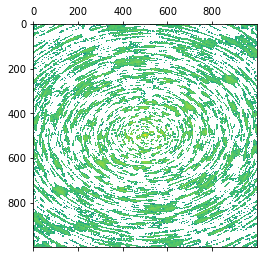

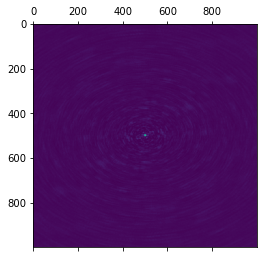

In [7]:
plt.matshow(np.log10(psf))
plt.matshow(psf)
plt.show()

In [13]:
# The central of the PSF is normalized to one
# find the coordinate of the centre pixel, which will be used in the process to make the covariance matrix below.
center_psf_y, center_psf_x = 500, 500
psf[center_psf_y,center_psf_x]

1.0

## Construct a covariance matrix M from the PSF for a $L\times L$ square region

In [16]:
# pixlen is L. Here we make a covariance matrix of a 130x130 square region
# make sure the PSF is large enough so that a "pixlen" away from the centre pixel of the PSF will not get out of the PSF
pixlen=130

# the covariance matrix will be stored in M
M=np.zeros((pixlen*pixlen,pixlen*pixlen))

k=0
for i in range(pixlen):
    for j in range(pixlen):
        a=psf[center_psf_y-i:center_psf_y+pixlen-i:1,center_psf_x-j:pixlen+center_psf_x-j:1]
        alin=util.image2array(a)
        M[k]=alin
        k=k+1

In [17]:
# check that the covariance matrix is actually symmetric. 
# (this command is not needed at all and may take a long time, feel free to delete it)
np.min(np.abs(M-M.T))

0.0

## Digonalize the covariance matrix M
- get all the eigen values and eigen vectors of M
- eigen values are stored in D
- eigen vectors are stored in P.T (the transpose of P)

In [18]:
# diagonalize the covariance matrix, this will take a long time to finish.
D,P=np.linalg.eigh(M)

In [19]:
P

array([[ 2.15334396e-04,  2.75331160e-04,  3.43677484e-05, ...,
         3.12912087e-03, -2.06384293e-03,  2.36009268e-03],
       [-1.15344622e-03, -2.31595748e-04,  4.61133355e-05, ...,
         2.95271305e-03, -2.23853259e-03,  2.51922746e-03],
       [ 1.69506585e-03, -8.28890546e-04,  1.23905360e-04, ...,
         2.72376020e-03, -2.40816579e-03,  2.67194218e-03],
       ...,
       [-1.69506364e-03, -8.28895106e-04, -1.23905462e-04, ...,
         2.72376020e-03, -2.40816579e-03, -2.67194218e-03],
       [ 1.15344687e-03, -2.31592628e-04, -4.61132650e-05, ...,
         2.95271305e-03, -2.23853259e-03, -2.51922746e-03],
       [-2.15335142e-04,  2.75330574e-04, -3.43678025e-05, ...,
         3.12912087e-03, -2.06384293e-03, -2.36009268e-03]])

In [20]:
# you can check here that the number of eigenvalues are the dimension of the image space, here 130x130=16900
np.shape(D)

(16900,)

## Sort the eigen modes in an eigen value descending order
- the sorted eigen values are saved in  Eigen_values
- the correspondingly sorted eigen vectors are saved in  Eigen_vectors

In [21]:
idx=D.argsort()[::-1]

In [22]:
# may take a long time
Eigen_vectors=P.T[idx]

In [23]:
Eigen_values=D[idx]

## View the eigen values $\sigma^2_i$
- Theoretically all eigen values should be non-negative. But we will find a tail with some tiny negative $\sigma^2$ when the dimension of the image space is really much larger than the d.o.f of the noise.

In [17]:
Eigen_values

array([ 1.29556209e+03,  9.00295286e+02,  8.29346451e+02, ...,
       -3.92889951e-06, -3.94846871e-06, -3.96156486e-06])

- draw the histogram of the eigenvalues

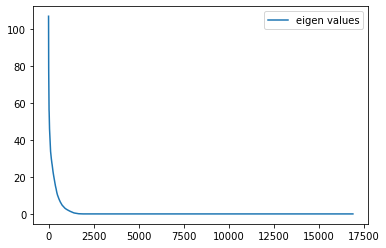

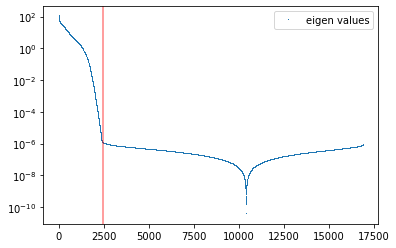

In [39]:
x=np.linspace(1,pixlen*pixlen,pixlen*pixlen)

plt.plot(x,Eigen_values,label='eigen values')
plt.legend()
plt.show()

plt.plot(x,np.abs(Eigen_values),',',label='eigen values')
plt.axvline(x=2450,color='r',alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

- In the above histogram, we indeed see the nagative tail of the eigen values. 
- The negative tail might be the errors arosen in the process of data collecting or computational, so we must ignore them. 
- In addtion, the negative tail seems to provide a cutoff value of the eigen values above which the corresponding eigen modes contribute to the real noise mode. 
- We empirically cut off the modes by the sudden change point of the pattern of log histogram (indicated by the red line in the above diagram), since the sudden change point seems to give the same level of $\sigma^2$ as the ones of the negative tail.

- <font color='red'>Warning: the above reason is not sufficient to conclude that the modes been cut off are really redundant. However, from the practice of fitting the real data, we find that the modes cut off contribute very little to the $\chi^2$ compared to the modes not cut off. Hence we can confirm that there should be such a cutoff.</font>

## View the eigen modes $v_i$

Now let us take a look at the eigen vectors. Since we have sorted the eigen modes in an descending order of the eigen values, the eigen mode [0] corresponds to the largest eigen value while the eigen mode [-1] corresponds to the lowest eigen value (which is negative and we should discard it by the above discussion). Now let us take a look of these eigen modes of the image space. You will find that:
- The eigen vectors of large eigen values have larger strctures.
- The eigen vectors of tiny eigen values have smaller strctures, and the tiny structure modes are the ones we cut off.

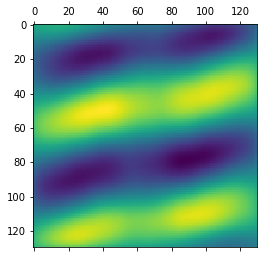

In [40]:
# the largest mode
# since Eigen_vectors[0] is a 1D (16900) array, we use util.array2image to translate it to a 2D (130,130) array
plt.matshow(util.array2image(Eigen_vectors[0]))

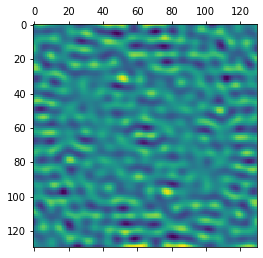

In [43]:
# a middle scale mode
plt.matshow(util.array2image(Eigen_vectors[550]))

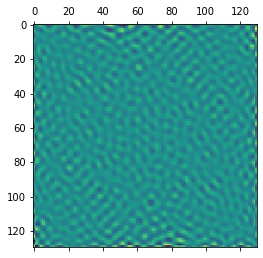

In [44]:
# a small scale mode
plt.matshow(util.array2image(Eigen_vectors[2000]))

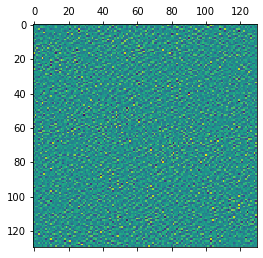

In [45]:
# a tiny scale mode, been cut off
plt.matshow(util.array2image(Eigen_vectors[10000]))

In [47]:
# you can verify the orthonormality of the eigen modes
np.sum(Eigen_vectors[1]*Eigen_vectors[1])

0.9999999999999997

## Now we have generated the covariance matrix, save them into files and load them from files when doing a fitting
Since we do not need to make a new covariance matrix when we are fitting just one image for multiple times. It is a better choice to save the generated eigen values and vectors into files rather than constructing them in the fitting program right before the fitting.

Remember that
- M is the covariance matrix
- Eigen_values stores the eigen values (sorted in a descending sequence)
- Eigen_vectors stores the corresponding eigen modes.
- Eigen_vectors[i] is the eigen vector of the image space, so it is a 1D ($L^2$) array and has a corresponding $\sigma^2$ Eigen_values[i]. It is necessary to guarantee the match up of the eigen modes and the corresponding eigen values by the same index i.

We only need to save Eigen_values and the Eigen_vectors. You can choose to save the entire array of Eigen_values and the Eigen_vectors or to just save the ones not been cut off.

In [ ]:
FileEigValue=open('\lenstronomy\Eigen_values.npy',"wb")
np.save(FileEigValue,Eigen_values)
FileEigValue.close()

FileEigVec=open('\lenstronomy\Eigen_vectors.npy',"wb")
np.save(FileEigVec,Eigen_vectors)
FileEigVec.close()